# CSE327 Homework 5
**Due date: 23:59 on May 8, 2022 (Sunday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [ ]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
import torch.optim as optim

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set your working directory (in your google drive) 
#   change it to your specific homework directory.
%cd '/content/gdrive/My Drive/Lin_Qinpeng_114141189_hw5'

/content/gdrive/My Drive/Lin_Qinpeng_114141189_hw5


In [ ]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
  #
  # Write your code here
  # normalize img pixels to [-1, 1]
  #
  norm_img = np.asarray(img)
  norm_img = norm_img.astype('float32')
  return (norm_img/225 - 0.5) * 2
def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                rotate_90=False, zero_centered=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
            
    #
    # Write your Data Augmentation code here
    # mirroring
    #
    if augment: 
      aug_data = [cv2.flip(img, 1) for img in data]
      data.extend(aug_data)
      labels.extend(labels)        
    #
    # Write your Data Normalization code here
    # norm data to zero-centered
    #
    if zero_centered:
      for i in range(len(data)):
        mean, std = cv2.meanStdDev(data[i])
        data[i] = (data[i] - mean) 
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Flower', 1: 'Bedroom', 2: 'OpenCountry', 3: 'Suburb', 4: 'Street', 5: 'Industrial', 6: 'Office', 7: 'Kitchen', 8: 'TallBuilding', 9: 'LivingRoom', 10: 'Store', 11: 'InsideCity', 12: 'Mountain', 13: 'Coast', 14: 'Highway', 15: 'Forest'} 


In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
4800
50
Finish loading 96 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class:

Industrial


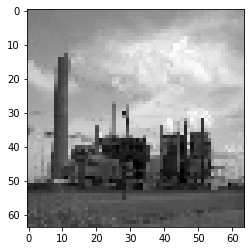

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

# Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) **you should be able to achieve around 50% test accuracy**. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [ ]:
# ==========================================
#       Define Network Architecture
# ==========================================
class network(nn.Module):
    def __init__(self):
        super(network,self).__init__()
        
        self.features = torch.nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),   
            nn.Dropout(0.5)
        )
      
        self.classifier = nn.Sequential(
            nn.Linear(3600, 16),
            nn.Dropout(0.5),
        )

    def forward(self, x):
        x = self.features(x)  
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  
    

In [ ]:
# ==========================================
#         Optimize/Train Network
# ==========================================
def train_net(net, dataloader, option):  
    loss_func = option['loss']()
    lr = option['lr']
    epoch = option['max_epoch']

    if 'optimizer' in option:
        optimizer = option['optimizer']
    else:
        optimizer = optim.Adam(net.parameters(), lr=lr)

    start_time = time.time()
    net.train()
    
    running_loss = 0.0
    steps = 0
    
    for ep in range(epoch):
        for iteration, (x, y) in enumerate(dataloader):
            batch_x = x.float().to(device)
            batch_y = y.long().to(device)
            outputs = net(batch_x)
            loss = loss_func(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            steps += 1
            running_loss += loss.item()
            
            if iteration % 5 == 0:
                time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
                print(f'Epoch:{ep:2d} | Iter:{iteration:5d} | Time: {time_lapse} | Train Loss: {loss.item():.4f} | Average Loss: {running_loss / steps:.4f}')

def test_net(net, dataloader):
    acc = 0.0
    count = 0
    start_time = time.time()
    net.eval()

    for x, y in dataloader:
        count += x.shape[0]
        batch_x = x.float().to(device)
        batch_y = y.long()
        outputs = net(batch_x).cpu()
        acc += torch.sum(outputs.max(1)[1]==batch_y)
    time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
    return acc / count, time_lapse


In [ ]:
# ==========================================
#            Evaluating Network
# ==========================================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = network().to(device)
train_option = {'lr': 0.005, 'max_epoch': 30, 'loss': nn.CrossEntropyLoss}
train_net(net, trainloader_small, train_option)

train_acc, on_train_time = test_net(net, trainloader_small)
test_acc, on_test_time = test_net(net, testloader_small)

print(f"Accuracy of StrongerNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of StrongerNet on the test set: {test_acc:.5f} | Time: {on_test_time}")

Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7706 | Average Loss: 2.7706
Epoch: 0 | Iter:    5 | Time: 00:00:00 | Train Loss: 3.8119 | Average Loss: 4.4816
Epoch: 0 | Iter:   10 | Time: 00:00:00 | Train Loss: 3.8605 | Average Loss: 4.1284
Epoch: 0 | Iter:   15 | Time: 00:00:00 | Train Loss: 3.0951 | Average Loss: 3.9328
Epoch: 0 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.9334 | Average Loss: 3.7062
Epoch: 0 | Iter:   25 | Time: 00:00:00 | Train Loss: 2.6762 | Average Loss: 3.5298
Epoch: 0 | Iter:   30 | Time: 00:00:00 | Train Loss: 2.7040 | Average Loss: 3.4081
Epoch: 0 | Iter:   35 | Time: 00:00:00 | Train Loss: 2.6738 | Average Loss: 3.3097
Epoch: 0 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.3433 | Average Loss: 3.2140
Epoch: 0 | Iter:   45 | Time: 00:00:00 | Train Loss: 2.7230 | Average Loss: 3.1500
Epoch: 0 | Iter:   50 | Time: 00:00:00 | Train Loss: 2.7607 | Average Loss: 3.0936
Epoch: 0 | Iter:   55 | Time: 00:00:00 | Train Loss: 2.4751 | Average Loss: 3.0398
Epoc

**Answer:**

Data augmentation: Flipped every image left to right and added to the dataset

Data normalization: scaled down pixel values to range of [-1, 1] and subtracted every pixel with mean value of all the pixels from all the images in the dataset.

Layer 1: In Convolution Layer, 16 Convolution Filters of shape 3*3 with ReLU activation and max pooling is applied. 

Layer 2: In NN layer, used 3600 input nodes with dropout(0.5) and 16 output nodes

...

Accuracy on test set: 50.75  

## Part2
List each of the techniques you used and the performances after using these techniques
<br> Please clearly indicate the techniques you use in the text blocks

In [ ]:
# ==========================================
#       Technique1
# ==========================================
class t1Net(nn.Module):
    def __init__(self):
      super(t1Net,self).__init__()  
           
      self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      self.layer2 = torch.nn.Sequential(
        nn.Conv2d(64, 128, 3),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(4608, 16), 
      )
      self.dropout = nn.Dropout(0.5)
      
    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)  
      x = torch.flatten(x, 1)
      x = self.dropout(x)
      x = self.classifier(x)
      return x  
     
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = t1Net().to(device)
train_option = {'lr': 0.005, 'max_epoch': 30, 'loss': nn.CrossEntropyLoss}
train_net(net, trainloader_small, train_option)

train_acc, on_train_time = test_net(net, trainloader_small)
test_acc, on_test_time = test_net(net, testloader_small)

print(f"Accuracy of StrongerNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of StrongerNet on the test set: {test_acc:.5f} | Time: {on_test_time}")      

Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8830 | Average Loss: 2.8830
Epoch: 0 | Iter:    5 | Time: 00:00:00 | Train Loss: 4.2464 | Average Loss: 6.1053
Epoch: 0 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.8030 | Average Loss: 4.7048
Epoch: 0 | Iter:   15 | Time: 00:00:00 | Train Loss: 2.7968 | Average Loss: 4.1109
Epoch: 0 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.8059 | Average Loss: 3.7962
Epoch: 0 | Iter:   25 | Time: 00:00:00 | Train Loss: 2.7733 | Average Loss: 3.5995
Epoch: 0 | Iter:   30 | Time: 00:00:00 | Train Loss: 2.7837 | Average Loss: 3.4680
Epoch: 0 | Iter:   35 | Time: 00:00:00 | Train Loss: 2.7631 | Average Loss: 3.3710
Epoch: 0 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.7632 | Average Loss: 3.2980
Epoch: 0 | Iter:   45 | Time: 00:00:00 | Train Loss: 2.7597 | Average Loss: 3.2404
Epoch: 0 | Iter:   50 | Time: 00:00:01 | Train Loss: 2.7699 | Average Loss: 3.1946
Epoch: 0 | Iter:   55 | Time: 00:00:01 | Train Loss: 2.7649 | Average Loss: 3.1568
Epoc

**Answer**:

Technique 1: Model Modification + Activation Function: 

 Layer1 - Convolution : nn.Conv2d(1, 64, 3), \ nn.ReLU(), \ nn.MaxPool2d(4, stride=4) 

 Layer2 - Convolution: nn.Conv2d(64, 128, 3), \ nn.Sigmoid(), \ nn.MaxPool2d(2, stride=2) 
 
 Layer3 -Dense NN - nn.Linear(4608, 16) 
 
 nn.Dropout(0.5)

Accuracy on test set: 63.25

Accuracy increases/decreases: Increases

In [ ]:
# ==========================================
#       Technique2
# ==========================================
class t2Net(nn.Module):
    def __init__(self):
      super(t2Net,self).__init__()  
           
      self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      self.layer2 = torch.nn.Sequential(
        nn.Conv2d(64, 128, 3),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2), 
      )
      
      self.classifier1 = nn.Sequential(
         nn.Linear(4608, 1024), 
         nn.BatchNorm1d(1024),
         nn.ReLU(),
      )
      self.classifier2 = nn.Sequential(
         nn.Linear(1024, 16),
      )

      self.dropout = nn.Dropout(0.5)
      
    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)  
      x = torch.flatten(x, 1)
      x = self.dropout(x)
      x = self.classifier1(x)
      x = self.classifier2(x)
      return x  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = t2Net().to(device)
train_option = {'lr': 0.005, 'max_epoch': 30, 'loss': nn.CrossEntropyLoss}
train_net(net, trainloader_small, train_option)

train_acc, on_train_time = test_net(net, trainloader_small)
test_acc, on_test_time = test_net(net, testloader_small)

print(f"Accuracy of StrongerNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of StrongerNet on the test set: {test_acc:.5f} | Time: {on_test_time}")           

Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8167 | Average Loss: 2.8167
Epoch: 0 | Iter:    5 | Time: 00:00:00 | Train Loss: 2.9456 | Average Loss: 3.1300
Epoch: 0 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.8312 | Average Loss: 3.0644
Epoch: 0 | Iter:   15 | Time: 00:00:00 | Train Loss: 2.7691 | Average Loss: 3.0138
Epoch: 0 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.7340 | Average Loss: 2.9495
Epoch: 0 | Iter:   25 | Time: 00:00:00 | Train Loss: 2.7385 | Average Loss: 2.8759
Epoch: 0 | Iter:   30 | Time: 00:00:01 | Train Loss: 2.0359 | Average Loss: 2.8069
Epoch: 0 | Iter:   35 | Time: 00:00:01 | Train Loss: 2.4847 | Average Loss: 2.7576
Epoch: 0 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.0678 | Average Loss: 2.7039
Epoch: 0 | Iter:   45 | Time: 00:00:01 | Train Loss: 2.4409 | Average Loss: 2.6614
Epoch: 0 | Iter:   50 | Time: 00:00:01 | Train Loss: 2.0189 | Average Loss: 2.6126
Epoch: 0 | Iter:   55 | Time: 00:00:01 | Train Loss: 2.4864 | Average Loss: 2.5765
Epoc

**Answer:**

Technique 2: Adding more layers with batch normalisation:

Layer1 - Convolution : nn.Conv2d(1, 64, 3),\ nn.BatchNorm2d(64) \ nn.ReLU(), \ nn.MaxPool2d(4, stride=4) 

 Layer2 - Convolution: nn.Conv2d(64, 128, 3), \ nn.Sigmoid(), \ nn.MaxPool2d(2, stride=2) 
 
 Layer3 -Dense NN - nn.Linear(4608, 1024), \ nn.BatchNorm2d(1024) \ nn.ReLu 

 Layer4 -Dense NN - nn.Linear(4608, 16) 
 
 nn.Dropout(0.5)
 
Accuracy on test set: 66

Accuracy increases/decreases: Increases

In [ ]:
# ==========================================
#       Technique3
# ==========================================
class t3Net(nn.Module):
    def __init__(self):
        super(t3Net,self).__init__()
        
        self.features = torch.nn.Sequential( 
            nn.Conv2d(1, 32,  3),
            nn.LeakyReLU(),
            nn.MaxPool2d(3, stride=3), #16, 20, 20  
            nn.Conv2d(32, 16, 3), #16, 18, 18 
            nn.LeakyReLU(),
            nn.MaxPool2d(3, stride=3), #16, 6, 6
            nn.Dropout(0.5)
        )
      
        self.classifier = nn.Sequential(
            nn.Linear(16 * 6 * 6, 212), 
            nn.BatchNorm1d(212),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(212, 16) 
        )

    def forward(self, x):
        x = self.features(x)  
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = t3Net().to(device)
train_option = {'lr': 0.005, 'max_epoch': 30, 'loss': nn.CrossEntropyLoss}
train_net(net, trainloader_small, train_option)

train_acc, on_train_time = test_net(net, trainloader_small)
test_acc, on_test_time = test_net(net, testloader_small)

print(f"Accuracy of StrongerNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of StrongerNet on the test set: {test_acc:.5f} | Time: {on_test_time}")         

Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.0491 | Average Loss: 3.0491
Epoch: 0 | Iter:    5 | Time: 00:00:00 | Train Loss: 2.4731 | Average Loss: 2.7857
Epoch: 0 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.7432 | Average Loss: 2.7563
Epoch: 0 | Iter:   15 | Time: 00:00:00 | Train Loss: 2.7971 | Average Loss: 2.7392
Epoch: 0 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.6084 | Average Loss: 2.7050
Epoch: 0 | Iter:   25 | Time: 00:00:00 | Train Loss: 2.4568 | Average Loss: 2.6726
Epoch: 0 | Iter:   30 | Time: 00:00:00 | Train Loss: 2.2559 | Average Loss: 2.6276
Epoch: 0 | Iter:   35 | Time: 00:00:00 | Train Loss: 2.4787 | Average Loss: 2.6106
Epoch: 0 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.3242 | Average Loss: 2.5848
Epoch: 0 | Iter:   45 | Time: 00:00:00 | Train Loss: 2.6868 | Average Loss: 2.5587
Epoch: 0 | Iter:   50 | Time: 00:00:00 | Train Loss: 2.2944 | Average Loss: 2.5340
Epoch: 0 | Iter:   55 | Time: 00:00:00 | Train Loss: 2.2710 | Average Loss: 2.5105
Epoc

**Answer:**

Technique 3: Activation Function. Tried various activation Functions and found that LeakyReLU worked better than ReLU. 

Accuracy on test set: 68.5

Accuracy increases/decreases: Increase

# Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [ ]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
2400
50
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class:

**Strategy B**

In [ ]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
import torchvision.models as models
alexnet_b = models.alexnet(pretrained=True)
alexnet_b.classifier[6] = nn.Linear(4096,16)

train_option = {'lr': 0.0001, 'max_epoch': 20, 'loss': nn.CrossEntropyLoss} 
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet_b.train()
alexnet_b = alexnet_b.to(device)
train_net(alexnet_b, trainloader_large, train_option)

train_acc, on_train_time = test_net(alexnet_b, trainloader_large)
test_acc, on_test_time = test_net(alexnet_b, testloader_large)

print(f"Accuracy of StrongerNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of StrongerNet on the test set: {test_acc:.5f} | Time: {on_test_time}")
alexnet_b

Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.1144 | Average Loss: 3.1144
Epoch: 0 | Iter:    5 | Time: 00:00:01 | Train Loss: 1.9435 | Average Loss: 2.4150
Epoch: 0 | Iter:   10 | Time: 00:00:01 | Train Loss: 1.0947 | Average Loss: 1.9589
Epoch: 0 | Iter:   15 | Time: 00:00:02 | Train Loss: 0.8670 | Average Loss: 1.6540
Epoch: 0 | Iter:   20 | Time: 00:00:03 | Train Loss: 0.8358 | Average Loss: 1.4705
Epoch: 0 | Iter:   25 | Time: 00:00:04 | Train Loss: 0.8288 | Average Loss: 1.3378
Epoch: 0 | Iter:   30 | Time: 00:00:05 | Train Loss: 0.6229 | Average Loss: 1.2421
Epoch: 0 | Iter:   35 | Time: 00:00:06 | Train Loss: 0.7821 | Average Loss: 1.1704
Epoch: 0 | Iter:   40 | Time: 00:00:07 | Train Loss: 0.8164 | Average Loss: 1.1054
Epoch: 0 | Iter:   45 | Time: 00:00:07 | Train Loss: 0.4765 | Average Loss: 1.0460
Epoch: 1 | Iter:    0 | Time: 00:00:08 | Train Loss: 0.4072 | Average Loss: 1.0124
Epoch: 1 | Iter:    5 | Time: 00:00:09 | Train Loss: 0.4408 | Average Loss: 0.9557
Epoc

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Answer**

(1)which layers of AlexNet have been replaced

  Only the last layer of the network was changed. Instead of the linear layer from 4096 input features to 1000 output features in the original AlexNet architecture, we change it to 16 output features for the purpose of this classification.

(2) the architecture of the new layers added including activation methods (same as problem 1)

Layer 1: Convolution 1 (3 input channel, 64 output channels, 11x11 kernels, 4px stride, 2px padding) with Relu and Max Pooling (3x3 kernel, 2px stride, 0px padding)

Layer 2: Convolution 2 (64 input channel, 192 output channels, 5x5 kernels, 1px stride, 2px padding) with Relu and Max Pooling (3x3 kernel, 2px stride, 0px padding)

Layer 3: Convolution 3 (192 input channels, 384 output channels, 3x3 kernels, 1px stride, 1px padding) with Relu

Layer 4: Convolution 4 (384 input channels, 256 output channels, 3x3 kernels, 1px stride, 1px padding) with Relu

Layer 5: Convolution 5 (256 input channels, 256 output channels, 3x3 kernels, 1px stride, 1px padding) with Relu and Max Pooling (3x3 kernel, 2px stride, 0px padding)

Layer 6: Adaptive Avg Pool (avgpool): output: 6x6 with Dropout (p = 0.5)

FC Layer 1 (in_features=9216, out_features=4096) with Relu and Dropout (p = 0.5)

FC Layer 2 (in_features=4096, out_features=4096) with Relu

FC Layer 3 (in_features=4096, out_features=16)

(3) the final accuracy on test set along with time consumption for both training and testing

Accuracy on test set: 86.5

# **Part 2: Implement Strategy A **

In [ ]:
alexnet_a = models.alexnet(pretrained=True)
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#getting features from alexnet#
def extract_features(net, dataloader):
  feat = []
  label = []
  for iteration, (x, y) in enumerate(dataloader):
        batch_x = x.float().to(device)
        batch_y = y.float().to(device)
        outputs = net.features(batch_x)
        feat.append(outputs.detach().cpu().numpy().flatten().reshape(len(x), 256 * 6 * 6))
        label += list(batch_y.detach().cpu().numpy())
  feat = np.vstack(feat)
  label = np.array(label)
  return feat, label

alexnet_a = alexnet_a.to(device)
train_feat, train_label = extract_features(alexnet_a, trainloader_large)
test_feat, test_label = extract_features(alexnet_a, testloader_large)

#trainning svm with extracted features#
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(train_feat, train_label)

start_time = time.time()
train_label_pred = clf.predict(train_feat)
mid_time = time.time()
test_label_pred = clf.predict(test_feat)
end_time = time.time()

train_acc = sum(np.array(train_label_pred) == train_label) / float(len(train_label))
on_train_time = time.strftime('%H:%M:%S', time.gmtime(mid_time - start_time))
test_acc = sum(np.array(test_label_pred) == test_label) / float(len(test_label))
on_test_time = time.strftime('%H:%M:%S', time.gmtime(end_time - mid_time))

print(f"Accuracy of AlexNet feature + one-vs-all SVM on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of AlexNet feature + one-vs-all SVM on the test set: {test_acc:.5f} | Time: {on_test_time}")

Accuracy of AlexNet feature + one-vs-all SVM on the training set: 0.99208 | Time: 00:01:02
Accuracy of AlexNet feature + one-vs-all SVM on the test set: 0.84000 | Time: 00:00:10


**Answer:** 

Accuracy on the test set: 84 

**Bonus: compare Alexnet with vgg**

In [ ]:
import torchvision.models as models

vgg = models.vgg16(pretrained=True)

#fine-tune the vgg by replace the last layer
vgg.classifier[6] = nn.Linear(4096, 16)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
train_option = {'lr': 0.0001, 'max_epoch': 20, 'loss': nn.CrossEntropyLoss}
vgg.train()
vgg = vgg.to(device)
train_net(vgg, trainloader_large, train_option)

train_acc, on_train_time = test_net(vgg, trainloader_large)
test_acc, on_test_time = test_net(vgg, testloader_large)

print(f"Accuracy of StrongerNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of StrongerNet on the test set: {test_acc:.5f} | Time: {on_test_time}")   

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoch: 0 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.8437 | Average Loss: 2.8437
Epoch: 0 | Iter:    5 | Time: 00:00:05 | Train Loss: 2.1463 | Average Loss: 2.5116
Epoch: 0 | Iter:   10 | Time: 00:00:08 | Train Loss: 1.2959 | Average Loss: 2.1424
Epoch: 0 | Iter:   15 | Time: 00:00:12 | Train Loss: 0.8674 | Average Loss: 1.8035
Epoch: 0 | Iter:   20 | Time: 00:00:16 | Train Loss: 0.8035 | Average Loss: 1.6074
Epoch: 0 | Iter:   25 | Time: 00:00:20 | Train Loss: 0.7859 | Average Loss: 1.4478
Epoch: 0 | Iter:   30 | Time: 00:00:24 | Train Loss: 0.7298 | Average Loss: 1.3377
Epoch: 0 | Iter:   35 | Time: 00:00:28 | Train Loss: 0.4675 | Average Loss: 1.2322
Epoch: 0 | Iter:   40 | Time: 00:00:32 | Train Loss: 0.6105 | Average Loss: 1.1613
Epoch: 0 | Iter:   45 | Time: 00:00:36 | Train Loss: 0.7502 | Average Loss: 1.0986
Epoch: 1 | Iter:    0 | Time: 00:00:38 | Train Loss: 0.4226 | Average Loss: 1.0660
Epoch: 1 | Iter:    5 | Time: 00:00:42 | Train Loss: 0.4720 | Average Loss: 1.0047
Epoc

**Answer:**

VGG spends more than 13 mins for finish 20 epochs. Compare to AlexNet which spend 2 mins and 41 seconds for 20 epochs. Therefore VGG is worse in the time cost aspect, But it is better in term of accury which comapre 90.25 to 86.5 

**Note:**
VGG requirs larger RAM to complete the implement. My free version of Colab doesn't provide enough RAM. SO, if you have error due to the capacity of RAM, just empty all the steps, star over with run the few base steps(1 ~ 9 "Optimize/Train Network"), steps 8 "reload data with a larger size" and directly run the last bnous one.

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw5' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
```

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw5.zip" for homework5 in this structure:
```
Jordan_Michael_111134567_hw5
        |---Jordan_Michael_111134567_hw5.ipynb
        |---Jordan_Michael_111134567_hw5.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter ***the TA's email***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

## Attention on HW submission
---
Based on the issues we observed during HW1 grading, we would like to ***stress*** the following.

* Submit the ***zip file*** containing (a notebook, pdf of sharable link, results) on Blackboard, ***not only*** the pdf with link.

* Link in the pdf should be directed to the ***folder*** on Google Drive, not the notebook alone.

* ***DO NOT*** change the structure of the notebook. If you need additional codes, just add new cells. ***DO NOT*** delete existing cells.

* Notebook should run without errors by by clicking ***'run all'*** . Verify this before submission. Because we need to run all your notebooks for grading. (Your folder structure, paths on Google Drive should be correct. If you do your HW locally on Jupyter and upload later to Google Drive, ***run and verify*** this on Colab to avoid any ***PENALTY***.)

* ***DO NOT*** remove the outputs visualized in the notebook. We check both the codes and the outputs.

* Make sure you submit the notebook in which you coded your answers.

* Read the questions ***carefully***, as they may contain sub parts or even hints.

* Share your notebook with ***EDIT ACCESS*** to ***the TA***: ***sounak.mondal@stonybrook.edu***. Uncheck the Notify people box.

If you don’t follow these instructions you will be penalized and the grading will be significantly delayed.



<!--Write your report here in markdown or html-->


In [ ]:
# import db here
def showhelp():
    print('usage: python main.py <options>')
    print('===== options =====')
    print('-h or --help to print this menu.')
    print('-l or --list to list all tasks.')
    print('-a or --add <DESCRIPTION> to add a new task')
    print('-p or --priority <NUMBER> to assign a priority to a new task. Must use with -a or -s.')
    print('-r or --remove <ID> remove a task.')
    print('-c or --complete <ID> mark a task as complete.')
    print('-cp or --changepriority <ID> <NUMBER> change an existing task\'s priority.')
    print('-u or --update <ID> <DESCRIPTION> update an existing task\'s description.')
    print('-s or --search <OPTIONS> search a task by options.')
    print('-t or --sort show sorted list of tasks by increasing order of priority.')
    print('-d or --desc decreasing order of priority. Must use with -t.')
    print('-i or --id <ID> task ID. Must use with -s for search task with ID.')
    print('-dp or --description <TEXT> task description. Must use with -s for search task with description.')

# command to list all tasks
def list_all_tasks_cmd():
    pass

# command to add a task
def add_task_cmd(task, priority):
    manager.create()

# command to delete a task
def remove_task_cmd(id):
    pass

# command to complete a task
def complete_task_cmd(id):
    pass

# command to edit task priority
def change_priority_cmd(id, priority):
    pass

# command to edit task description
def update_cmd(id, desc):
    pass

# command to search a task by id, description, or priority
def search_cmd(id, desc, priority):
    pass

# command to sort the tasks in specified order
def sort_cmd(order):
    pass